
# Spark Tutorial. Part 2 - Learning Apache Spark SQL and analyzing logs


After the completion of the first practical lesson you got basic understanding of the transformations and actions in Spark.      

Now it's time to move onto the more advanced Spark's capability - [Spark SQL](https://spark.apache.org/sql/). In this lab we will analyze a partial log of the recommender system.

Spark SQL is a Spark's module for working with *structured data*. Structured data can always be described with some schema. So lets prepare, parse and structure the data that you will use in this tutorial.

First, we need to create a `SQLContext` instance.  This is an important step which allows us to work with structured data (rows and columns) in Spark, create `DataFrames` and execute SQL queries.      

*Note: SQL (Structured Query Language) is a special purpose language, designed for data management and stream processing of the relational databases.  The scope of SQL includes data insert, query, update and delete, schema creation and modification, and data access control. Khowledge of SQL is a must for a data scientist since a lot of the data is stored in relational databases.* 

###  Preparation

Let's create `SQLContext` instance.

In [1]:
import os
# export PYSPARK_PYTHON=/usr/bin/python3
# export PYSPARK_DRIVER_PYTHON=ipython3
# export PYSPARK_DRIVER_PYTHON_OPTS="notebook"
# os.environ["PYSPARK_DRIVER_PYTHON"] = "/home/dmitriy/.local/lib/python3.6/site-packages"
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3.6"
# os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook"
# os.environ["SPARK_HOME"] = "/usr/local/spark/spark-2.4.0-bin-hadoop2.7"

In [2]:
from pyspark import SparkContext
sc = SparkContext("local", "First App")

In [3]:
from pyspark.sql import *
sqlContext = SQLContext(sc)

The file with server logs, that we will analyze, is called `apache_log_lab2`. Let's read it line by line and count rows.

In [4]:
log_file = sc.textFile('apache_log_lab2').cache()

print ('Read {} lines'.format(log_file.count()))

assert log_file.count() == 260356

Read 260356 lines


This is example of Apache web server log. Every row looks like       
`127.0.0.1 - frank [10/Oct/2000:13:55:36 -0700] "GET /apache_pb.gif HTTP/1.0" 200 2326`

Each part of this log entry is described [here](http://httpd.apache.org/docs/1.3/logs.html#common).

Now let's try to use the `parse_log_line()` function to parse every line of log file.

In [8]:
import re

# Regular expression pattern.
LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] \"(\S+) (\S+)\s*(\S*)\" (\d{3}) (\S+)'

def parse_log_line(logline):
    match = re.search(LOG_PATTERN, logline)
    if match is None:
        return (logline, False) # False means that parsing failed.
    size_field = match.group(9)
    if size_field == '-':
        size = int(0)
    else:
        size = int(match.group(9))
    return (Row(
        host          = match.group(1),
        client_identd = match.group(2),
        user_id       = match.group(3),
        date_time     = match.group(4),
        method        = match.group(5),
        endpoint      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = size
    ), True)

In [9]:
def parse_log():
    parsed_logs = log_file.map(parse_log_line)    
    logs = parsed_logs.filter(lambda s: s[1] == True).map(lambda s: s[0])
    failed_logs = parsed_logs.filter(lambda s: s[1] == False).map(lambda s: s[0])
    
    failed_logs_count = failed_logs.count()
    if failed_logs_count > 0:
        print ('Number of invalid log lines: {}'.format(failed_logs.count()))
        for line in failed_logs.take(5):
            print ('Invalid: {}'.format(line))

    print ('Read {} lines, parsed {} lines, failed {} lines'.format(parsed_logs.count(), logs.count(), failed_logs.count()))
    return parsed_logs, logs, failed_logs

In [10]:
parsed_logs, logs, failed_logs = parse_log()

Number of invalid log lines: 23
Invalid: ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:44:13 -0400] "GET /images/USA-logosmall.gif HTTP/1.0 " 200 234
Invalid: ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:44:15 -0400] "GET /images/WORLD-logosmall.gif HTTP/1.0 " 200 669
Invalid: ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:45:34 -0400] "GET /images/KSC-logosmall.gif HTTP/1.0 " 200 1204
Invalid: ix-sac6-20.ix.netcom.com - - [08/Aug/1995:14:45:48 -0400] "GET /htbin/cdt_main.pl HTTP/1.0 " 200 3714
Invalid: ix-li1-14.ix.netcom.com - - [08/Aug/1995:14:46:38 -0400] "GET /images/USA-logosmall.gif HTTP/1.0 " 200 234
Read 260356 lines, parsed 260333 lines, failed 23 lines


## Exercise 1

You might have noticed that the `parse_log_line()` failed to parse 23 lines, because they do not match the LOG_PATTERN [regular expression](https://docs.python.org/2/library/re.html#regular-expression-objects).

Examine invalid lines and modify the `LOG_PATTERN` in the cell below so that the failed lines will be parsed correctly.

*Note: you may want to use https://regex101.com/ to test your regular expression*. 

In [12]:
# Exercise 1
LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] \"(\S+) (\S+)\s*(\S*)\s?\" (\d{3}) (\S+)'
parsed_logs, logs, failed_logs = parse_log()
logs.cache()

Read 260356 lines, parsed 260356 lines, failed 0 lines


PythonRDD[20] at RDD at PythonRDD.scala:53

In [8]:
# TEST
import sys, os
sys.path.append("/usr/local/lib/python2.7/site-packages")
dir_path = os.path.dirname(os.path.realpath('Lab_1/Lab_1_SPARK.ipynb'))
sys.path.append('/home/vagrant/.local/lib/python2.7/site-packages')

from test_helper_spark import *

In [9]:
# Test

lab2_test_ex_1(logs)

1 test passed. Correct logs count: 260356
1 test passed. Correct logs: [Row(client_identd=u'-', content_size=0L, date_time=u'01/Aug/1995:00:00:08 -0400', endpoint=u'/images/ksclogo-medium.gif', host=u'uplherc.upl.com', method=u'GET', protocol=u'HTTP/1.0', response_code=304, user_id=u'-'), Row(client_identd=u'-', content_size=0L, date_time=u'01/Aug/1995:00:00:08 -0400', endpoint=u'/images/USA-logosmall.gif', host=u'uplherc.upl.com', method=u'GET', protocol=u'HTTP/1.0', response_code=304, user_id=u'-'), ...]


## Exercise 2

Now we have an RDD containing the log file as a collection of Row objects.
 
Your task is to compute some statistics about the sizes of content being returned from the web server. To compute the minimum and maximum statistics, we can use [`min()`](http://spark.apache.org/docs/1.6.3/api/python/pyspark.html#pyspark.RDD.min) and [`max()`](http://spark.apache.org/docs/1.6.3/api/python/pyspark.html#pyspark.RDD.max). To compure average content size use [`sum()`](http://spark.apache.org/docs/1.6.3/api/python/pyspark.html#pyspark.RDD.sum).

In [13]:
# Exercise 2

content_sizes = logs.map(lambda log: log.content_size).cache()

content_size_avg = content_sizes.sum() / content_sizes.count()
content_size_min = content_sizes.min()
content_size_max = content_sizes.max()

print ('Avg: {}, Min: {}, Max: {}'.format(content_size_avg, content_size_min, content_size_max))

Avg: 17646.85671926132, Min: 0, Max: 3155499


In [11]:
# Test
lab2_test_ex_2(content_size_avg, content_size_min, content_size_max)

1 test passed. Correct avg size: 17646
1 test passed. Correct min size: 0
1 test passed. Correct max size: 3155499


Now, let's visualize the results from the last example. We can do it using [`matplotlib`](http://matplotlib.org/). For this visualisation we use a [`histogram`](https://en.wikipedia.org/wiki/Histogram) representation.

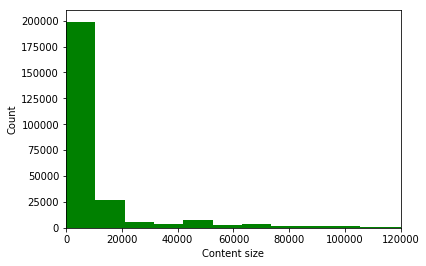

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(content_sizes.collect(), bins=300, facecolor='g')
plt.axis([0, 120000, 0, 210000])
plt.xlabel('Content size')
plt.ylabel('Count')
plt.show()

Let's make the `sqlContext` to work with our parsed logs using [`createDataFrame`](https://spark.apache.org/docs/1.6.3/api/python/pyspark.sql.html#pyspark.sql.SQLContext.createDataFrame). Also register the data frame as a table using [`registerTempTable`](https://spark.apache.org/docs/1.6.3/api/python/pyspark.sql.html#pyspark.sql.DataFrame.registerTempTable) function.

In [15]:
log_schema = sqlContext.createDataFrame(logs)
log_schema.registerTempTable('logs')

Now we can print schema of our table in the tree format using [`printSchema`](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.printSchema)

In [16]:
log_schema.printSchema()

root
 |-- client_identd: string (nullable = true)
 |-- content_size: long (nullable = true)
 |-- date_time: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- host: string (nullable = true)
 |-- method: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- response_code: long (nullable = true)
 |-- user_id: string (nullable = true)



Now, apart from using already known transformations, we can get all unique `response_code` fields with a simple SQL query.

In [17]:
unique_response_code = sqlContext.sql('SELECT DISTINCT response_code FROM logs')
print (unique_response_code.take(3))

[Row(response_code=304), Row(response_code=404), Row(response_code=500)]


We got an RDD of `DataFrame` objects as a result of the query. For better visualisation we'd like to extract an integer field from each `Row`. 

In [19]:
responses = unique_response_code.rdd.map(lambda p: p.response_code)
print (responses.take(3))

[304, 404, 500]


We can use the following query to get the count of unique responses.

In [22]:
unique_response_code_count = sqlContext.sql("SELECT COUNT(DISTINCT response_code) FROM logs")

# The result is returned as the _c0 field in a Row object 
print (unique_response_code_count.collect())
# print (unique_response_code_count.rdd.map(lambda p: p._c0).first())

[Row(count(DISTINCT response_code)=7)]


## Exercise 3

Create a **`response_code_counts`** dataset with the occurrences of each response code in logs using only Spark **transformations**.

*Note: **`response_code_counts`** is a key-value dataset, in which keys is a response code and value is a corresponding number of occurrences.*

*Hint: you may want to use the [`reduceByKey`](http://spark.apache.org/docs/1.6.3/api/python/pyspark.html#pyspark.RDD.reduceByKey) function to sum up values with the same key value.*

In [23]:
# Exercise 3

response_code_counts = logs.map(lambda log: (log.response_code, 1)) \
                           .reduceByKey(lambda a, b: a + b) \
                           .collect()

print ('Response code counts: {}'.format(response_code_counts))

Response code counts: [(304, 19852), (200, 234881), (302, 4074), (404, 1528), (403, 16), (500, 2), (501, 3)]


In [19]:
# Test
lab2_test_ex_3(response_code_counts)

1 test passed. Correct RDD: [(200, 234881), (302, 4074), (304, 19852), (403, 16), (404, 1528), (501, 3), (500, 2)]


## Exercise 4

Create a **`response_code_counts`** dataset with the occurrences of each response code in logs using only **SQL queries**.

*Note: **`response_code_counts`** is a key-value dataset, in which key is a response code and value is a corresponding number of occurrences.*

*Hint: You may want to use the [`GROUP BY`](http://www.w3schools.com/sql/sql_groupby.asp) statement to group data and [`ALIAS`](http://www.w3schools.com/sql/sql_alias.asp) to rename queryable fields to pass the tests*.

In [25]:
# Exercise 4

response_code_counts = sqlContext.sql('''
    SELECT response_code, COUNT(*) AS count_records FROM logs
    GROUP BY response_code
''').rdd.map(lambda row: (row.response_code, row.count_records)).collect()

print ('Response code counts: {}'.format(response_code_counts))

Response code counts: [(304, 19852), (404, 1528), (500, 2), (501, 3), (403, 16), (200, 234881), (302, 4074)]


In [21]:
# Test
lab2_test_ex_4(response_code_counts)

1 test passed. Correct RDD: [(500, 2), (501, 3), (302, 4074), (304, 19852), (200, 234881), (403, 16), (404, 1528)]


Now, let's visualize the results from this example. We will use the [`pie()`](http://matplotlib.org/examples/pie_and_polar_charts/pie_demo_features.html) method to create the pie plot. Don't go into details.

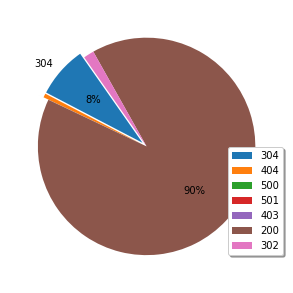

In [49]:
labels = list(map(lambda x: x[0], response_code_counts))
count = logs.count()
fracs = list(map(lambda y: float(y[1]) / count, response_code_counts))
explode = (0.05, 0.05, 0.1, 0, 0, 0, 0)

def pie_pct_format(value):
    """ Determine the appropriate format string for the pie chart percentage label"""
    return '' if value < 7 else '%.0f%%' % value

fig = plt.figure(figsize=(5, 5), facecolor='white')
patches, texts, autotexts = plt.pie(fracs, labels=labels, explode=explode, autopct=pie_pct_format, startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')  # If the slice is small to fit, don't show a text label
plt.legend(labels, loc=(0.80, 0.1), shadow=True)
pass

## Exercise 5

Let's look at hosts that accessed the server multiple times.

Create a **`top_10_hosts`** dataset with the top 10 of most popular hosts using only Spark **transformations**.

*Note: **`top_10_hosts`** is a key-value dataset, in which key is a host name and value is a corresponding number of connections to server.*

*Hint: You can replace both `sortBy()` and `take()` operations with the `takeOrdered()` action.*

In [50]:
# Exercise 5

top_10_hosts = logs.map(lambda log: (log.host, 1)) \
                   .reduceByKey(lambda a, b: a + b) \
                   .takeOrdered(10, lambda log: -log[1])

print ('Top 10 popular hosts: {}'.format(top_10_hosts))

Top 10 popular hosts: [('edams.ksc.nasa.gov', 1032), ('piweba5y.prodigy.com', 814), ('piweba4y.prodigy.com', 764), ('piweba3y.prodigy.com', 706), ('www-d1.proxy.aol.com', 655), ('www-b3.proxy.aol.com', 653), ('www-b2.proxy.aol.com', 626), ('news.ti.com', 621), ('www-d2.proxy.aol.com', 620), ('163.206.89.4', 616)]


In [24]:
# Test
lab2_test_ex_5(top_10_hosts)

1 test passed. Correct RDD: [(u'edams.ksc.nasa.gov', 1032), (u'piweba5y.prodigy.com', 814), (u'piweba4y.prodigy.com', 764), (u'piweba3y.prodigy.com', 706), (u'www-d1.proxy.aol.com', 655), (u'www-b3.proxy.aol.com', 653), (u'www-b2.proxy.aol.com', 626), (u'news.ti.com', 621), (u'www-d2.proxy.aol.com', 620), (u'163.206.89.4', 616)]


## Exercise 6

Create a **`top_10_hosts`** dataset with the top 10 of most popular hosts using only **SQL queries**.
   
*Note: **`top_10_hosts`** is a key-value dataset, in which key is a host name and value is a corresponding number of connections to server.*
   
*Hint: You may want to use [`ORDER BY`](https://www.w3schools.com/sql/sql_orderby.asp) keyword and [`LIMIT`](https://www.w3schools.com/php/php_mysql_select_limit.asp) clause and [`ALIAS`](https://www.w3schools.com/sql/sql_alias.asp) to rename queryable fields to pass the tests.*

In [52]:
# Exercise 6

top_10_hosts = sqlContext.sql('''
    SELECT host, COUNT(*) AS count_hosts FROM logs
    GROUP BY host
    ORDER BY count_hosts DESC LIMIT 10
''').rdd.map(lambda row: (row.host, row.count_hosts)).collect()

print ('Top 10 popular hosts: {}'.format(top_10_hosts))

Top 10 popular hosts: [('edams.ksc.nasa.gov', 1032), ('piweba5y.prodigy.com', 814), ('piweba4y.prodigy.com', 764), ('piweba3y.prodigy.com', 706), ('www-d1.proxy.aol.com', 655), ('www-b3.proxy.aol.com', 653), ('www-b2.proxy.aol.com', 626), ('news.ti.com', 621), ('www-d2.proxy.aol.com', 620), ('163.206.89.4', 616)]


In [27]:
# Test
lab2_test_ex_5(top_10_hosts)

1 test passed. Correct RDD: [(u'edams.ksc.nasa.gov', 1032), (u'piweba5y.prodigy.com', 814), (u'piweba4y.prodigy.com', 764), (u'piweba3y.prodigy.com', 706), (u'www-d1.proxy.aol.com', 655), (u'www-b3.proxy.aol.com', 653), (u'www-b2.proxy.aol.com', 626), (u'news.ti.com', 621), (u'www-d2.proxy.aol.com', 620), (u'163.206.89.4', 616)]


## Exercise 7

Create a **`top_20_endpoints_404`** dataset with the top 20 endpoints, that generated the most 404 errors, using only Spark **transformations**.

*Note: **`top_20_endpoints_404`** is a key-value dataset, in which key is an endpoint and value is a corresponding number of failed (404) requests.*

In [53]:
# Exercise 7

top_20_endpoints_404 = logs.filter(lambda log: log.response_code == 404) \
                           .map(lambda log: (log.endpoint, 1)) \
                           .reduceByKey(lambda a, b: a + b) \
                           .takeOrdered(20, lambda log: -log[1])

print ('Top 20 bad resources: {}'.format(top_20_endpoints_404))

Top 20 bad resources: [('/pub/winvn/readme.txt', 149), ('/pub/winvn/release.txt', 128), ('/shuttle/missions/STS-69/mission-STS-69.html', 114), ('/images/nasa-logo.gif', 64), ('/elv/DELTA/uncons.htm', 42), ('/shuttle/missions/sts-68/ksc-upclose.gif', 33), ('/history/apollo/sa-1/sa-1-patch-small.gif', 30), ('/images/crawlerway-logo.gif', 25), ('/://spacelink.msfc.nasa.gov', 23), ('/images/Nasa-logo.gif', 22), ('/shuttle/resources/orbiters/atlantis.gif', 21), ('/history/apollo/a-001/a-001-patch-small.gif', 20), ('/shuttle/resources/orbiters/discovery.gif', 19), ('/images/lf-logo.gif', 16), ('/robots.txt', 15), ('/shuttle/resources/orbiters/challenger.gif', 15), ('/history/apollo/images/little-joe.jpg', 14), ('/elv/new01.gif>', 13), ('/history/apollo/pad-abort-test-2/pad-abort-test-2-patch-small.gif', 13), ('/history/apollo/sa-2/sa-2-patch-small.gif', 12)]


In [29]:
# Test
lab2_test_ex_7(top_20_endpoints_404)

1 test passed. Correct RDD: [(u'/pub/winvn/readme.txt', 149), (u'/pub/winvn/release.txt', 128), (u'/shuttle/missions/STS-69/mission-STS-69.html', 114), (u'/images/nasa-logo.gif', 64), (u'/elv/DELTA/uncons.htm', 42), (u'/shuttle/missions/sts-68/ksc-upclose.gif', 33), (u'/history/apollo/sa-1/sa-1-patch-small.gif', 30), (u'/images/crawlerway-logo.gif', 25), (u'/://spacelink.msfc.nasa.gov', 23), (u'/images/Nasa-logo.gif', 22), (u'/shuttle/resources/orbiters/atlantis.gif', 21), (u'/history/apollo/a-001/a-001-patch-small.gif', 20), (u'/shuttle/resources/orbiters/discovery.gif', 19), (u'/images/lf-logo.gif', 16), (u'/robots.txt', 15), (u'/shuttle/resources/orbiters/challenger.gif', 15), (u'/history/apollo/images/little-joe.jpg', 14), (u'/history/apollo/pad-abort-test-2/pad-abort-test-2-patch-small.gif', 13), (u'/elv/new01.gif>', 13), (u'/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif', 12)]


## Exercise 8

Create a **`top_20_endpoints_404`** dataset with the top 20 endpoints, that generated the most 404 errors using, only **SQL queries**.

*Note: **`top_20_endpoints_404`** is a key-value dataset, in which key is an endpoint and value is a corresponding number of failed (404) requests.*

*Hint: You may want to use the [`WHERE`](https://www.w3schools.com/sql/sql_where.asp) clause to filter records.*

In [55]:
# Exercise 8

top_20_endpoints_404 = sqlContext.sql('''
    SELECT endpoint, count(*) AS count_endpoints FROM logs WHERE response_code = 404
    GROUP BY endpoint
    ORDER BY count_endpoints DESC LIMIT 20
''').rdd.map(lambda x: (x.endpoint, x.count_endpoints)).collect()

print ('Top 20 bad resources: {}'.format(top_20_endpoints_404))

Top 20 bad resources: [('/pub/winvn/readme.txt', 149), ('/pub/winvn/release.txt', 128), ('/shuttle/missions/STS-69/mission-STS-69.html', 114), ('/images/nasa-logo.gif', 64), ('/elv/DELTA/uncons.htm', 42), ('/shuttle/missions/sts-68/ksc-upclose.gif', 33), ('/history/apollo/sa-1/sa-1-patch-small.gif', 30), ('/images/crawlerway-logo.gif', 25), ('/://spacelink.msfc.nasa.gov', 23), ('/images/Nasa-logo.gif', 22), ('/shuttle/resources/orbiters/atlantis.gif', 21), ('/history/apollo/a-001/a-001-patch-small.gif', 20), ('/shuttle/resources/orbiters/discovery.gif', 19), ('/images/lf-logo.gif', 16), ('/robots.txt', 15), ('/shuttle/resources/orbiters/challenger.gif', 15), ('/history/apollo/images/little-joe.jpg', 14), ('/elv/new01.gif>', 13), ('/history/apollo/pad-abort-test-2/pad-abort-test-2-patch-small.gif', 13), ('/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif', 12)]


In [31]:
# Test
lab2_test_ex_8(top_20_endpoints_404)

1 test passed. Correct RDD: [(u'/pub/winvn/readme.txt', 149), (u'/pub/winvn/release.txt', 128), (u'/shuttle/missions/STS-69/mission-STS-69.html', 114), (u'/images/nasa-logo.gif', 64), (u'/elv/DELTA/uncons.htm', 42), (u'/shuttle/missions/sts-68/ksc-upclose.gif', 33), (u'/history/apollo/sa-1/sa-1-patch-small.gif', 30), (u'/images/crawlerway-logo.gif', 25), (u'/://spacelink.msfc.nasa.gov', 23), (u'/images/Nasa-logo.gif', 22), (u'/shuttle/resources/orbiters/atlantis.gif', 21), (u'/history/apollo/a-001/a-001-patch-small.gif', 20), (u'/shuttle/resources/orbiters/discovery.gif', 19), (u'/images/lf-logo.gif', 16), (u'/shuttle/resources/orbiters/challenger.gif', 15), (u'/robots.txt', 15), (u'/history/apollo/images/little-joe.jpg', 14), (u'/history/apollo/pad-abort-test-2/pad-abort-test-2-patch-small.gif', 13), (u'/elv/new01.gif>', 13), (u'/history/apollo/sa-2/sa-2-patch-small.gif', 12)]


## Exercise 9

Instead of looking at the endpoints that generated 404 errors, let's look at the hosts that generated 404 errors.

Create a **`top_11_hosts_404`** dataset with the top 11 hosts, that generated the most 404 errors, using only Spark **transformations**.

*Note: **`top_11_hosts_404`** is a key-value dataset, in which key is a host and value is a corresponding number of failed (404) requests.*

In [56]:
# Exercise 9

top_11_hosts_404 = logs.filter(lambda log: log.response_code == 404) \
                       .map(lambda log: (log.host, 1)) \
                       .reduceByKey(lambda a, b: a + b) \
                       .takeOrdered(11, lambda log: -log[1])
            
print ('Top 11 hosts that generated errors: {}'.format(top_11_hosts_404))

Top 11 hosts that generated errors: [('ts8-1.westwood.ts.ucla.edu', 13), ('www-c4.proxy.aol.com', 13), ('piweba3y.prodigy.com', 11), ('maz3.maz.net', 11), ('scooter.pa-x.dec.com', 8), ('204.62.245.32', 8), ('m38-370-9.mit.edu', 8), ('www-b5.proxy.aol.com', 7), ('dial055.mbnet.mb.ca', 7), ('www-c2.proxy.aol.com', 7), ('www-d4.proxy.aol.com', 7)]


In [33]:
# Test
lab2_test_ex_9(top_11_hosts_404)

1 test passed. Correct RDD: [(u'ts8-1.westwood.ts.ucla.edu', 13), (u'www-c4.proxy.aol.com', 13), (u'maz3.maz.net', 11), (u'piweba3y.prodigy.com', 11), (u'204.62.245.32', 8), (u'm38-370-9.mit.edu', 8), (u'scooter.pa-x.dec.com', 8), (u'www-d4.proxy.aol.com', 7), (u'www-b5.proxy.aol.com', 7), (u'dial055.mbnet.mb.ca', 7), (u'www-c2.proxy.aol.com', 7)]


## Exercise 10

Create a **`top_11_hosts_404`** dataset with the top 11 hosts, that generated the most 404 errors, using only **SQL queries**.

*Note: **`top_11_hosts_404`** is a key-value dataset, in which key is a host and value is a corresponding number of failed (404) requests.*

In [58]:
# Exercise 10

top_11_hosts_404 = sqlContext.sql('''
    SELECT host, count(*) AS count_hosts FROM logs WHERE response_code = 404
    GROUP BY host
    ORDER BY count_hosts DESC LIMIT 11
''').rdd.map(lambda x: (x.host, x.count_hosts)).collect()

print ('Top 11 hosts that generated errors: {}'.format(top_11_hosts_404))

Top 11 hosts that generated errors: [('ts8-1.westwood.ts.ucla.edu', 13), ('www-c4.proxy.aol.com', 13), ('maz3.maz.net', 11), ('piweba3y.prodigy.com', 11), ('m38-370-9.mit.edu', 8), ('scooter.pa-x.dec.com', 8), ('204.62.245.32', 8), ('www-b5.proxy.aol.com', 7), ('www-d4.proxy.aol.com', 7), ('www-c2.proxy.aol.com', 7), ('dial055.mbnet.mb.ca', 7)]


In [35]:
# Test
lab2_test_ex_10(top_11_hosts_404)

1 test passed. Correct RDD: [(u'www-c4.proxy.aol.com', 13), (u'ts8-1.westwood.ts.ucla.edu', 13), (u'maz3.maz.net', 11), (u'piweba3y.prodigy.com', 11), (u'm38-370-9.mit.edu', 8), (u'204.62.245.32', 8), (u'scooter.pa-x.dec.com', 8), (u'www-c2.proxy.aol.com', 7), (u'dial055.mbnet.mb.ca', 7), (u'www-b5.proxy.aol.com', 7), (u'www-d4.proxy.aol.com', 7)]


<hr>

**Congradulations!** Now you know how to use SQL queries as an alternative to transformations and actions. This can significantly speed up your work.

We strongly advise you to learn SQL if you are going to be a software developer or data scientist.

In the next practical lesson we will examine the `pyspark.mllib` module.

<center><h3>Presented by <a target="_blank" rel="noopener noreferrer nofollow" href="http://datascience-school.com">datascience-school.com</a></h3></center>